# Mean bias

Assessment of model mean bias.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

import utils

In [2]:
def calc_mean(da, var):
    """Calculate the mean"""
    
    if var == 'pr':
        mean = da.groupby('time.year').sum(dim="time").mean(dim='year')
    else:
        mean = da.groupby('time.year').mean(dim="time").mean(dim='year')
        
    return mean

In [3]:
def get_data(var, gcm, rcm, task):
    """Get data needed for the evaluation"""

    assert gcm in ['ECMWF-ERA5', 'CSIRO-ACCESS-ESM1-5']
    assert rcm in ['BOM-BARPA-R', 'CSIRO-CCAM-2203', 'UQ-DES-CCAM-2105']
    assert task in ['historical', 'xvalidation']

    if gcm == 'ECMWF-ERA5':
        start_date = '2000-01-01' if task == 'xvalidation' else '1980-01-01'
    else:
        start_date = '1990-01-01' if task == 'xvalidation' else '1980-01-01' 
    end_date = '2019-12-31'
    
    da_dict = {}
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['mean_obs'] = calc_mean(da_obs, var)
   
    da_dict['gcm'] = utils.get_npcp_data(
        var,
        gcm,
        'GCM',
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_raw'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'raw',
        'task-reference',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_ecdfm'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'ecdfm',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    da_dict['rcm_qme'] = utils.get_npcp_data(
        var,
        gcm,
        rcm,
        'qme',
        f'task-{task}',
        start_date,
        end_date,
        'AU'
    )
    if task == 'xvalidation':
        da_dict['rcm_qdm'] = utils.get_npcp_data(
            var,
            gcm,
            rcm,
            'qdm',
            f'task-{task}',
            start_date,
            end_date,
            'AU'
        )
        
    # TODO: Add additional bias correction methods as data becomes available 

    return da_dict

In [4]:
def plot_mean_bias(ax, mean_obs, da_model, var, cmap, levels, model_name, ob_fractions=None):
    """Plot the mean bias for a particular model"""
    
    mean_model = calc_mean(da_model, var)
    bias = mean_model - mean_obs
    bias = utils.clip_data(bias, utils.get_aus_shape())
    if ob_fractions is not None:
        bias = utils.mask_by_pr_ob_fraction(bias, ob_fractions, threshold=0.9)    
    rmse = np.sqrt(np.nanmean(bias.values**2))

    units = 'mm/year' if var == 'pr' else da_model.attrs['units']
    bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both',
        cbar_kwargs={'label': units},
    )
    ax.text(0.02, 0.02, f'RMSE: {rmse:.2f} {units}', transform=ax.transAxes)
    ax.set_title(model_name)
    ax.coastlines()

In [5]:
def plot_comparison(var, gcm, rcm, task, cmap, levels):
    """Plot the complete comparison"""

    da_dict = get_data(var, gcm, rcm, task)
    if var == 'pr':
        ob_fractions = utils.get_pr_weights(gcm, task)
    else:
        ob_fractions = None
    ncols = 5 if task == 'xvalidation' else 4
    
    fig = plt.figure(figsize=[7 * ncols, 5])
    ax1 = fig.add_subplot(1, ncols, 1, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax1, da_dict['mean_obs'], da_dict['gcm'], var, cmap, levels, gcm, ob_fractions=ob_fractions,
    )
    ax2 = fig.add_subplot(1, ncols, 2, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax2, da_dict['mean_obs'], da_dict['rcm_raw'], var, cmap, levels, f'{rcm} (raw)', ob_fractions=ob_fractions,
    )
    ax3 = fig.add_subplot(1, ncols, 3, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax3, da_dict['mean_obs'], da_dict['rcm_ecdfm'], var, cmap, levels, f'{rcm} (ecdfm)', ob_fractions=ob_fractions,
    )
    ax4 = fig.add_subplot(1, ncols, 4, projection=ccrs.PlateCarree())
    plot_mean_bias(
        ax4, da_dict['mean_obs'], da_dict['rcm_qme'], var, cmap, levels, f'{rcm} (qme)', ob_fractions=ob_fractions,
    )
    if task == 'xvalidation':
        ax5 = fig.add_subplot(1, ncols, 5, projection=ccrs.PlateCarree())
        plot_mean_bias(
            ax5, da_dict['mean_obs'], da_dict['rcm_qdm'], var, cmap, levels, f'{rcm} (qdm)', ob_fractions=ob_fractions,
        )
    long_name = da_dict['rcm_raw'].attrs['long_name']
    if gcm == 'ECMWF-ERA5':
        start_year = '2000' if task == 'xvalidation' else '1980'
    else:
        start_year = '1990' if task == 'xvalidation' else '1980'
    plt.suptitle(f'Bias (model minus obs) in the {start_year}-2019 annual mean {long_name}')
    plt.show()

## task-historical

Bias corrected data for the 1980-2019 period, using 1980-2019 as a training period.

In [6]:
variable = 'pr'
levels = np.arange(-475, 476, 50)
cmap = 'BrBG'

#### ERA5

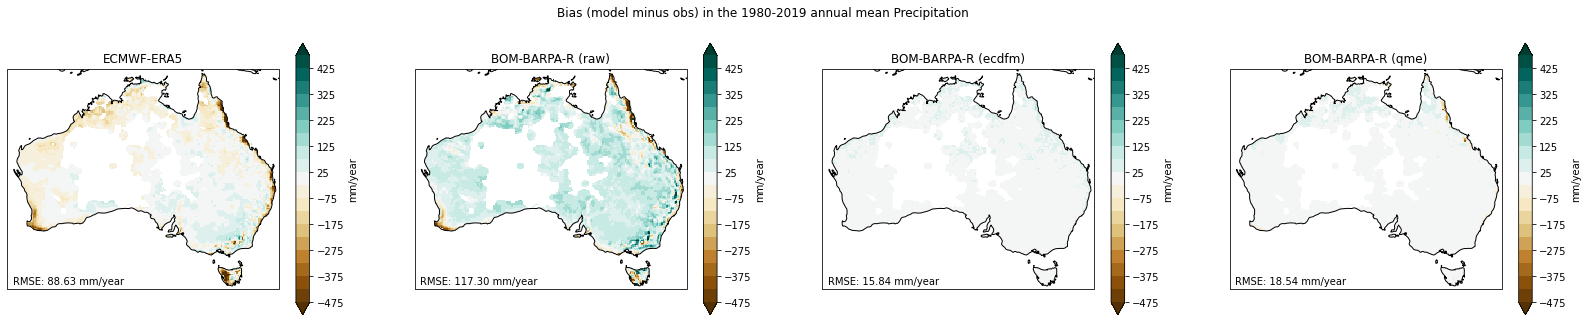

In [7]:
plot_comparison(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'historical', cmap, levels)

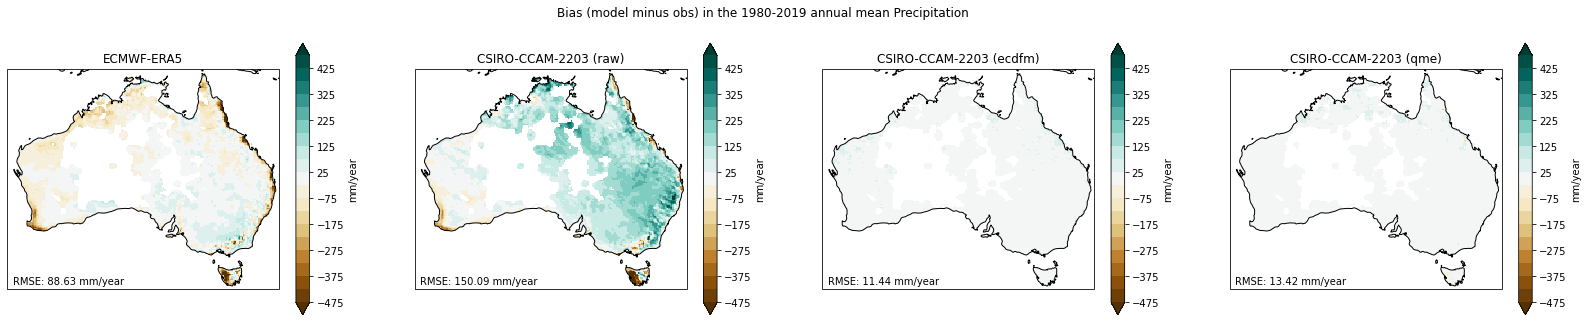

In [8]:
plot_comparison(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

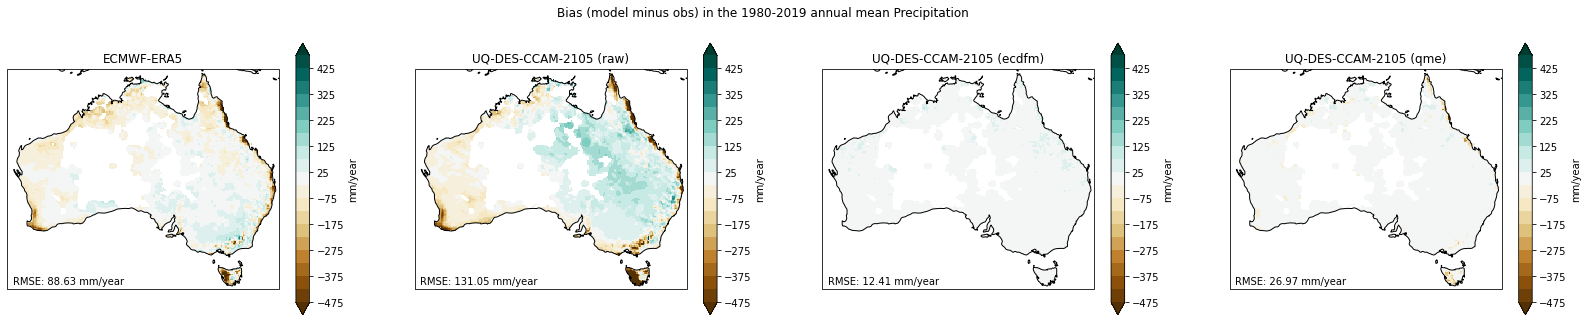

In [9]:
plot_comparison(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

#### ACCESS-ESM1-5

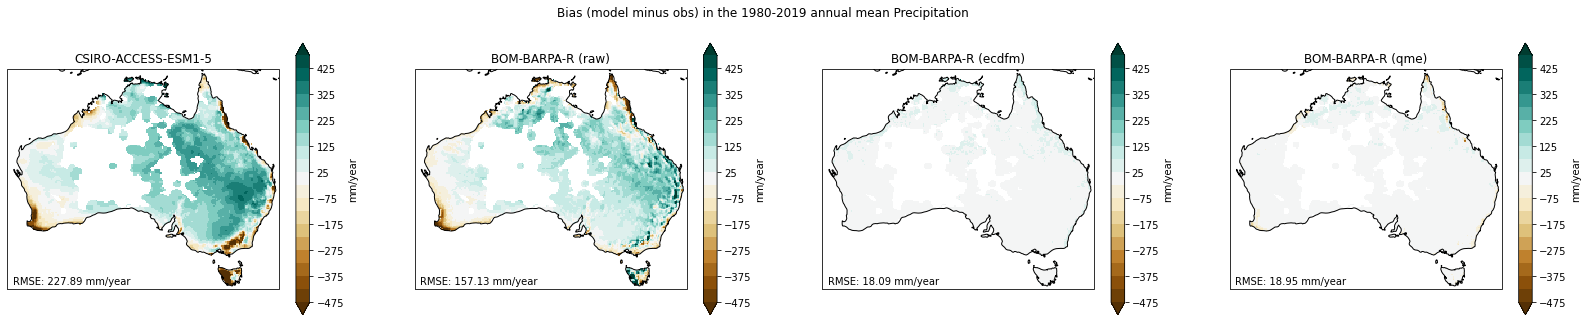

In [10]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'historical', cmap, levels)

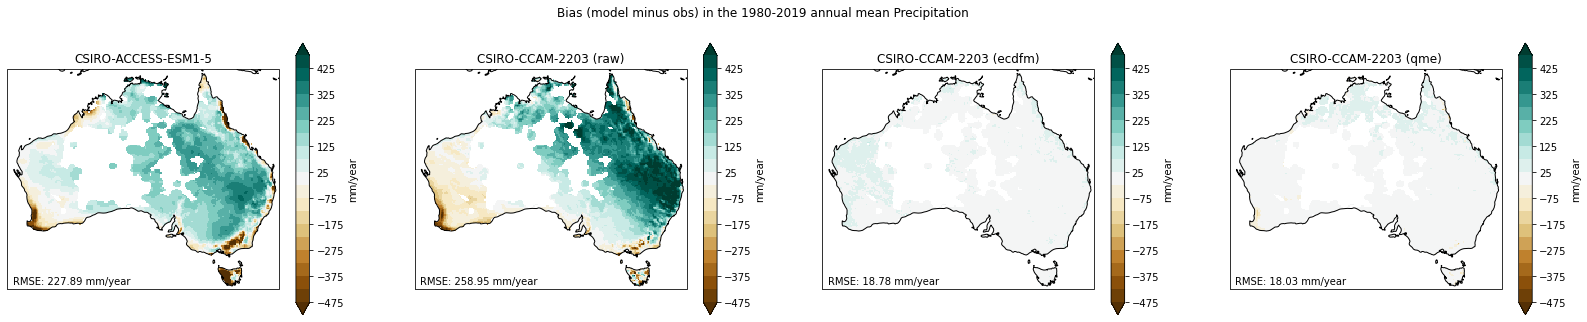

In [11]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'historical', cmap, levels)

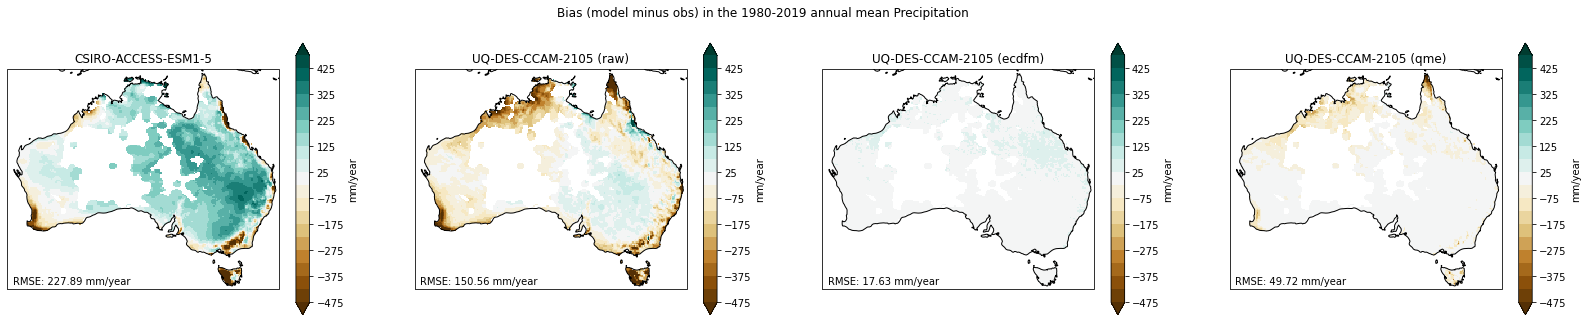

In [12]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'historical', cmap, levels)

## task-xvalidation

#### ERA5

Bias corrected data for the 2000-2019 period, using 1980-1999 as a training period.

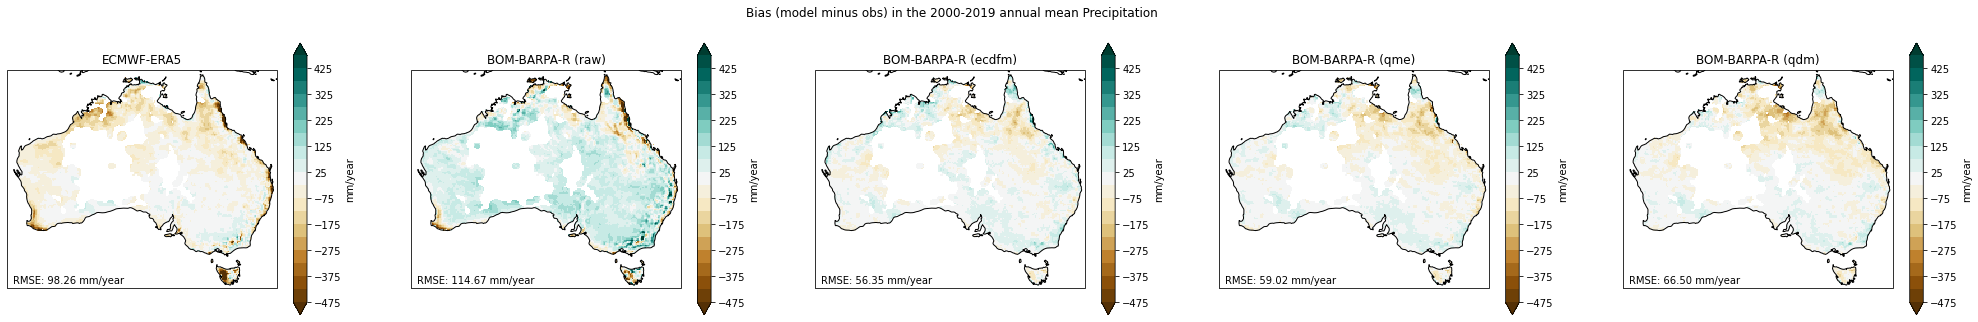

In [13]:
plot_comparison(variable, 'ECMWF-ERA5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

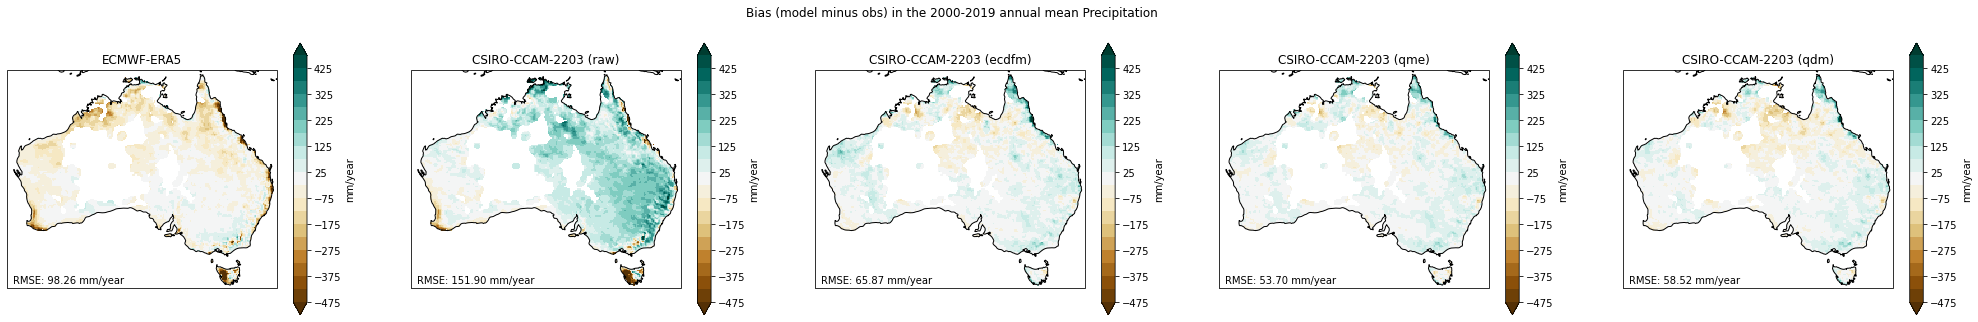

In [14]:
plot_comparison(variable, 'ECMWF-ERA5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

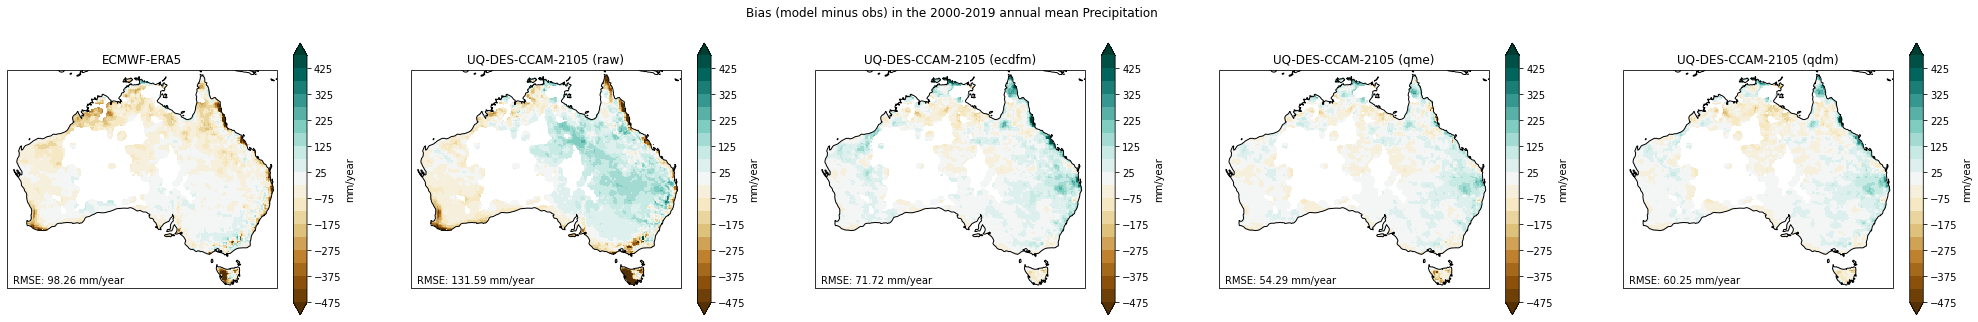

In [15]:
plot_comparison(variable, 'ECMWF-ERA5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)

#### ACCESS-ESM1-5

Bias corrected data for the 1990-2019 period, using 1960-1989 as a training period.

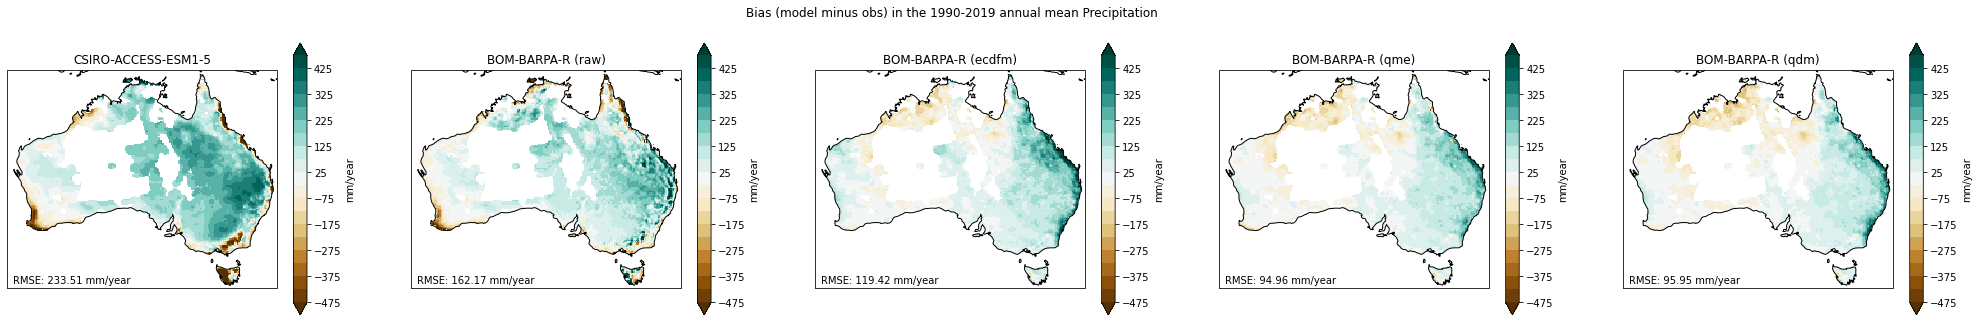

In [16]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'BOM-BARPA-R', 'xvalidation', cmap, levels)

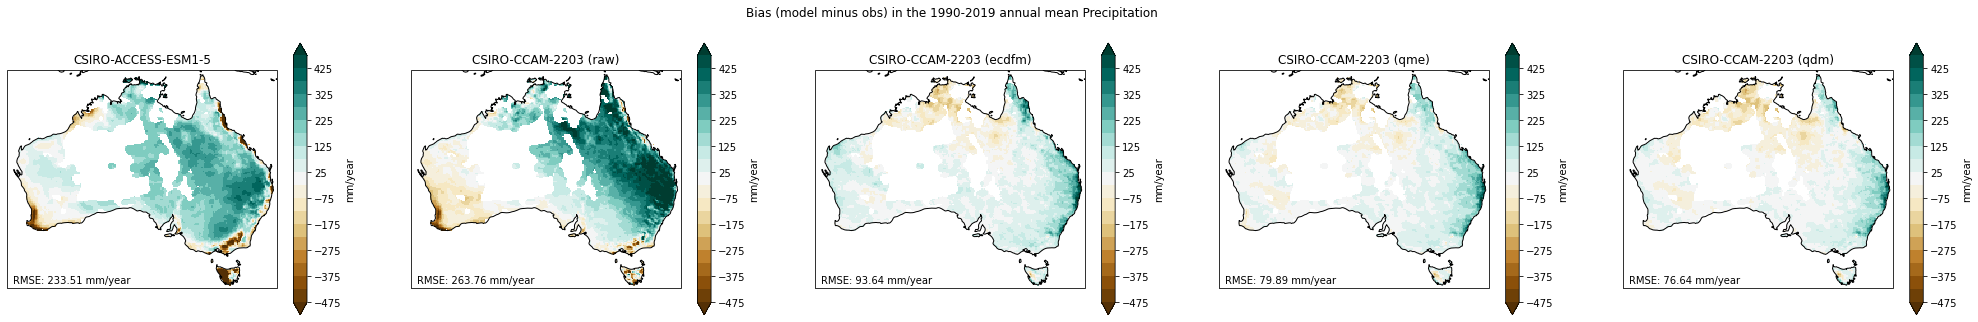

In [17]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'CSIRO-CCAM-2203', 'xvalidation', cmap, levels)

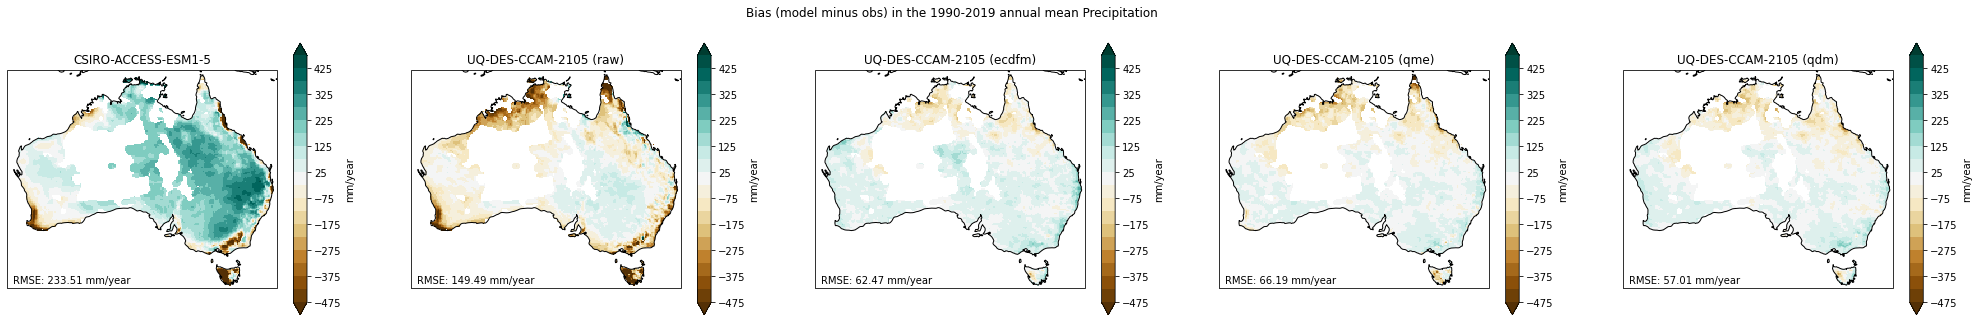

In [18]:
plot_comparison(variable, 'CSIRO-ACCESS-ESM1-5', 'UQ-DES-CCAM-2105', 'xvalidation', cmap, levels)